# PROBLEM 4: **SPORTS OR POLITICS**

Preprocessing text data...

--------------------------------------------------------------------------------
Dataset Exploration
--------------------------------------------------------------------------------
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8828 entries, 0 to 8827
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           8828 non-null   object
 1   short_description  8828 non-null   object
dtypes: object(2)
memory usage: 138.1+ KB
None

Sample Data:
   category                                  short_description
0  POLITICS  the american people have a right to know what ...
1    SPORTS  flvia saraiva is getting ready to go up agains...
2    SPORTS  laura trott and jason kenny are cruising throu...
3    SPORTS  because you cant start the nfl season without ...
4    SPORTS  gif via buzzfeedsports the daring touchdown re...

Number of duplicate rows: 76


/tmp/ipython-input-2221271767.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='category', data=data, palette='viridis')


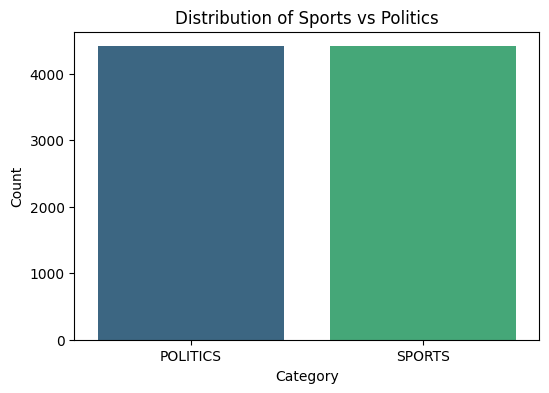

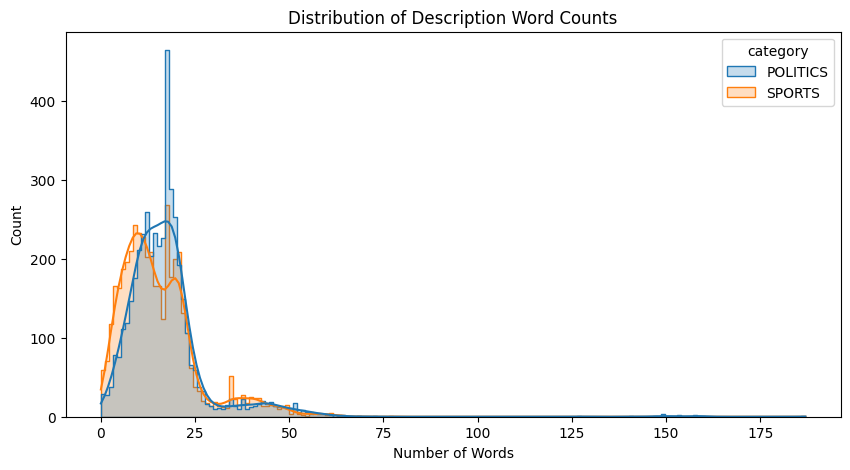


Average Word Count per Category:
category
POLITICS    17.391029
SPORTS      15.476439
Name: text_length, dtype: float64
--------------------------------------------------------------------------------

Filtered dataset shape: (8828, 3)

--------------------------------------------------------------------------------
Training and Evaluation Results
--------------------------------------------------------------------------------

Model: Bag of Words + Naive Bayes
Accuracy: 0.8652
Confusion Matrix:
               Pred POLITICS  Pred SPORTS
True POLITICS            777          106
True SPORTS              132          751
------------------------------------------------------------

Model: Bag of Words + Logistic Regression
Accuracy: 0.8607
Confusion Matrix:
               Pred POLITICS  Pred SPORTS
True POLITICS            738          145
True SPORTS              101          782
------------------------------------------------------------

Model: Bag of Words + Neural Network
Accuracy

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# defining the text preprocessing function
def preprocessing_text(text):
    if not isinstance(text, str):
        return ""

    # lowercasing
    text_lwr = text.lower()

    # removing URLs
    without_urls = re.sub(r'http\S+|www\S+|https\S+', '', text_lwr, flags=re.MULTILINE)

    # removing punctuation and number
    without_puncts = re.sub(r'[^a-z\s]', '', without_urls)

    # removing extra whitespaces
    cleaned_text = re.sub(r'\s+', ' ', without_puncts).strip()

    return cleaned_text

# function for data exploration
def explore_dataset(data):
    """
    Performs basic Exploratory Data Analysis (EDA) on the dataframe.
    """
    print(f"\n{'-'*80}")
    print(f"Dataset Exploration")
    print(f"{'-'*80}")

    # general information
    print("Dataset Info:")
    print(data.info())
    print("\nSample Data:")
    print(data.head())

    # checking for duplicates
    duplicates = data.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicates}")

    # visualizing Class Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='category', data=data, palette='viridis')
    plt.title('Distribution of Sports vs Politics')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.show()
    print('\n')

    # doing text length analysis
    # creating a temporary column for length
    data['text_length'] = data['short_description'].apply(lambda x: len(x.split()))

    plt.figure(figsize=(10, 5))
    sns.histplot(data=data, x='text_length', hue='category', kde=True, element="step")
    plt.title('Distribution of Description Word Counts')
    plt.xlabel('Number of Words')
    plt.show()

    print(f"\nAverage Word Count per Category:")
    print(data.groupby('category')['text_length'].mean())
    print(f"{'-'*80}\n")

# function to load the data from the csv file
def load_and_explore_data(file_path):
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: '{file_path}' not found.")
        return None, None

    # filtering for only 'sport' and 'politics'
    data_filtered = data[data['category'].isin(['SPORTS', 'POLITICS'])].copy()

    # filling NaN values
    data_filtered['short_description'] = data_filtered['short_description'].fillna('')

    # applying preprocessing
    print("Preprocessing text data...")
    data_filtered['short_description'] = data_filtered['short_description'].apply(preprocessing_text)

    # --- CALLING THE EXPLORATION FUNCTION ---
    explore_dataset(data_filtered)

    print(f"Filtered dataset shape: {data_filtered.shape}")

    return data_filtered['short_description'].values, data_filtered['category'].values


def train_and_evaluate(X_train, X_test, y_train, y_test, label_encoder):
    # defining the 3 classifiers
    classifiers = {
        "Naive Bayes": MultinomialNB(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Neural Network": MLPClassifier(
            hidden_layer_sizes=(256, 128, 64),
            activation='relu',
            solver='adam',
            alpha=0.0001,
            batch_size='auto',
            max_iter=500,
            early_stopping=True,
            random_state=42
        )
    }

    feat_extractors = {
        "Bag of Words": CountVectorizer(stop_words='english', max_features=10000),
        "TF-IDF": TfidfVectorizer(stop_words='english', max_features=10000),
        "N-Grams (1-3)": CountVectorizer(stop_words='english', ngram_range=(1, 3), max_features=10000)
    }

    results = {}

    print(f"\n{'-'*80}")
    print(f"Training and Evaluation Results")
    print(f"{'-'*80}")

    for feat_name, vectorizer in feat_extractors.items():
        for classifier_name, classifier in classifiers.items():

            # creating the build anf training pipeline
            model = make_pipeline(vectorizer, classifier)
            model.fit(X_train, y_train)

            # predicting
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)

            # Confusion Matrix calculations
            unique_labels_numerical = sorted(list(set(y_train)))
            conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_labels_numerical)
            unique_labels_original = label_encoder.inverse_transform(unique_labels_numerical)

            # creating a Pandas DataFrame for the Confusion Matrix
            cm_dataframe = pd.DataFrame(
                conf_matrix,
                index=[f"True {label}" for label in unique_labels_original],
                columns=[f"Pred {label}" for label in unique_labels_original]
            )

            # Save result
            key = f"{feat_name} + {classifier_name}"
            results[key] = model

            # Print Results
            print(f"\nModel: {feat_name} + {classifier_name}")
            print(f"Accuracy: {acc:.4f}")
            print("Confusion Matrix:")
            print(cm_dataframe)
            print("-" * 60)

    return results


# loading the data
file_name = '/content/News_Category_Dataset_v3.csv'
text, label = load_and_explore_data(file_name)

if text is not None and len(text) > 0:
    # encoding target labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(label)

    # splitting the data
    # Note: Fixed variable 'X' to 'text' below
    X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
        text, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
    )

    # training & comparing models
    models = train_and_evaluate(X_train, X_test, y_train_encoded, y_test_encoded, label_encoder)

    # testing on custom input
    print(f"\n{'='*60}")
    print("Testing on new custom sentences (Using N-Grams (1-3) + Naive Bayes):")
    print(f"{'='*60}")

    custom_texts = [
        "The quarterback threw a touchdown in the last second of the game.",
        "The senator filibustered the bill regarding tax reform.",
        "The election results were controversial due to the new policy.",
        "He hit a home run out of the park!",
        "Modi hit out at the opposition leaders in all three states before the election dates.",
        "labour targets hardcore truants a fresh crackdown on persistent truants in england has been launched by education secretary ruth kelly.",
        "The basketball team won the championship after an intense overtime period.",
        "Congress passed new legislation on healthcare reform yesterday.",
        "The striker scored a hat-trick in the final match of the season.",
        "The prime minister addressed parliament about foreign policy issues."
    ]

    # preprocessing the custom text
    custom_texts_clean = [preprocessing_text(t) for t in custom_texts]

    # using the specific model
    target_model = "N-Grams (1-3) + Naive Bayes"

    if target_model in models:
        best_model = models[target_model]
        predictions_encoded = best_model.predict(custom_texts_clean)
        predictions = label_encoder.inverse_transform(predictions_encoded)

        for original, label in zip(custom_texts, predictions):
            print(f"Text: '{original}'")
            print(f"Prediction: {label}")
            print("-" * 30)
    else:
        print(f"Model '{target_model}' not found.")
else:
    print("No data found or dataset is empty.")